In [1]:
import util
from difference_models import BinaryDifferenceClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import shap
from matplotlib import pyplot as plt
from copy import deepcopy
import numpy as np
import pandas as pd
import pickle
%matplotlib inline

In [2]:
try:
    with open('dataset.pickle', 'rb') as f:
        X, y, feature_names, n_features, n_samples = pickle.load(f)
        print('Loaded cached dataset')
except FileNotFoundError:
    print('No cached dataset found')

Loaded cached dataset


In [3]:
try:
    with open('classifiers.pickle', 'rb') as f:
        clf_a, clf_b = pickle.load(f)
        print('Loaded cached models')
except FileNotFoundError:
    print('No cached models found')

Loaded cached models


## Load Data

In [13]:
X, y = shap.datasets.iris()
feature_names = X.columns.to_numpy()
n_features = len(feature_names)
X = X.to_numpy()
n_samples = X.shape[0]
with open('dataset.pickle', 'wb') as f:
    pickle.dump((X, y, feature_names, n_features, n_samples), f, pickle.HIGHEST_PROTOCOL)

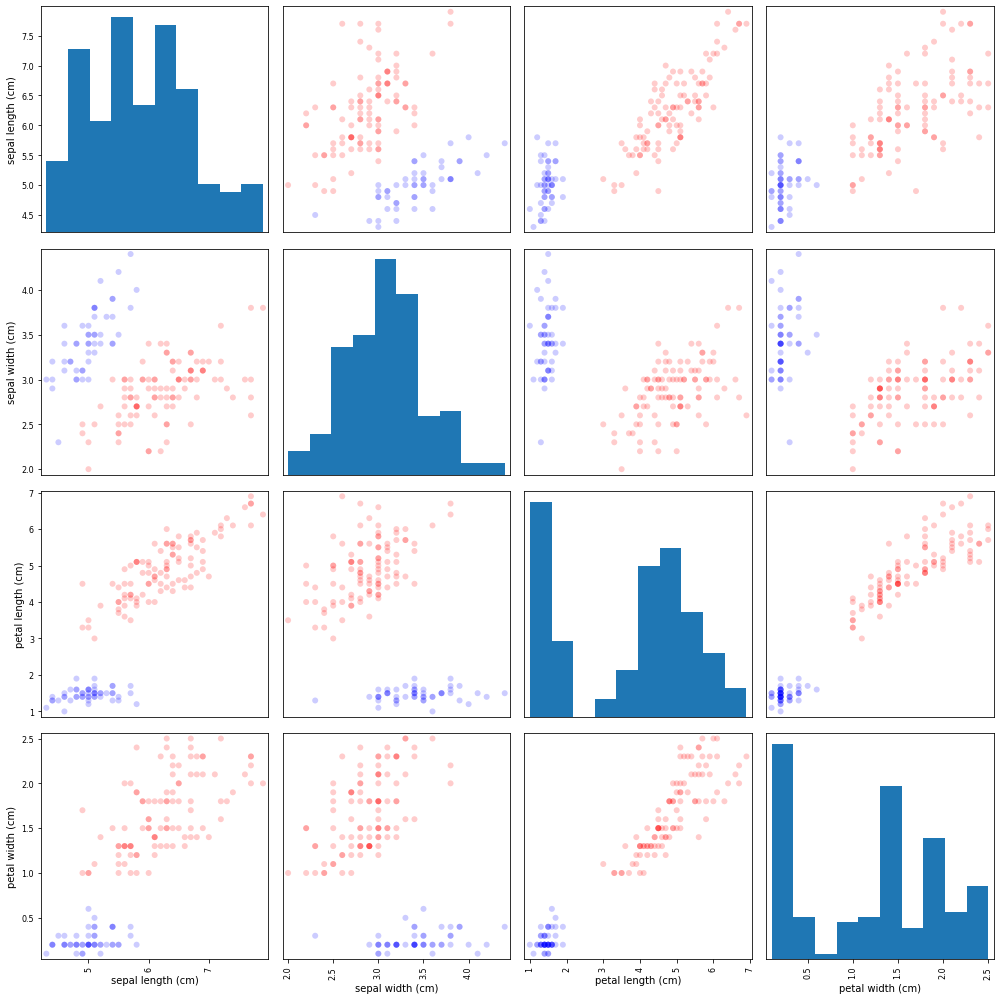

In [14]:
df = pd.DataFrame(X, columns=feature_names)
axes = pd.plotting.scatter_matrix(df, figsize=(14, 14), marker='o', alpha=0.2, c=['r' if y_ else 'b' for y_ in y])
plt.tight_layout()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=52)

## Train Models

In [20]:
%%time
clf_a = LogisticRegression(C=1.0, max_iter=10000)
clf_a.fit(X_train, y_train)
clf_b = deepcopy(clf_a)
clf_b.intercept_[2] += 1
clf_b.coef_[2, 0] += 0.1
clf_b.coef_[2, 1] += 0.1
with open('classifiers.pickle', 'wb') as f:
    pickle.dump((clf_a, clf_b), f, pickle.HIGHEST_PROTOCOL)

CPU times: user 70.8 ms, sys: 5.81 ms, total: 76.6 ms
Wall time: 91.9 ms


## Analyze Performance

In [22]:
pred_test_a = clf_a.predict(X_test)
pred_test_b = clf_b.predict(X_test)

In [23]:
print(classification_report(pred_test_a, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.91      0.95        11
           2       0.90      1.00      0.95         9

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [24]:
print(classification_report(pred_test_b, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.80      1.00      0.89         8
           2       1.00      0.83      0.91        12

    accuracy                           0.93        30
   macro avg       0.93      0.94      0.93        30
weighted avg       0.95      0.93      0.93        30



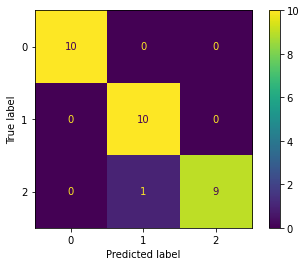

In [25]:
cm = confusion_matrix(y_test, pred_test_a, labels=clf_a.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_a.classes_)
disp.plot();

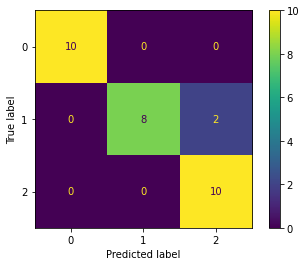

In [26]:
cm = confusion_matrix(y_test, pred_test_b, labels=clf_b.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_b.classes_)
disp.plot();

## Visualize Distributions of Predictions

In [37]:
indices = np.array(range(n_samples))
pred_a = clf_a.predict(X)
pred_b = clf_b.predict(X)
proba_a = clf_a.predict_proba(X)
proba_b = clf_b.predict_proba(X)
log_odds_a = util.calc_log_odds_from_log_proba(clf_a.predict_log_proba(X))
log_odds_b = util.calc_log_odds_from_log_proba(clf_b.predict_log_proba(X))

In [42]:
is_finite = np.all(np.isfinite(log_odds_a), axis=1) & np.all(np.isfinite(log_odds_b), axis=1)

Instances with non-finite log-odds predictions:

In [43]:
pd.DataFrame(X[~is_finite]).describe()

,0,1,2,3
count,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN


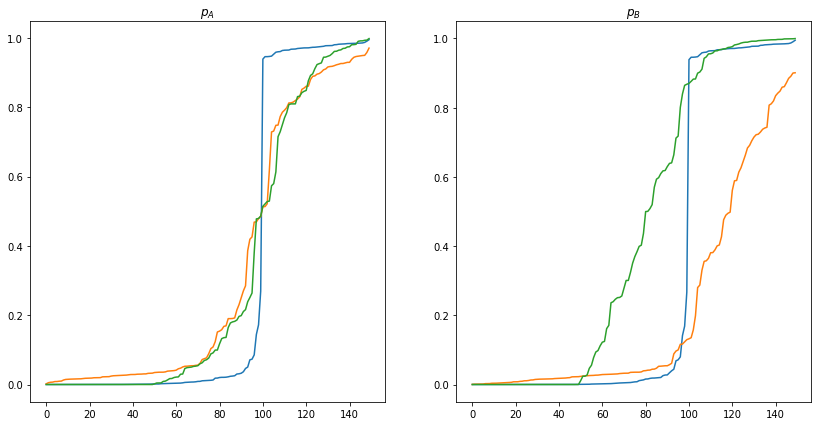

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7*2, 7))
ax1.set_title('$p_A$')
ax1.plot(np.sort(proba_a, axis=0))
ax2.set_title('$p_B$')
ax2.plot(np.sort(proba_b, axis=0));

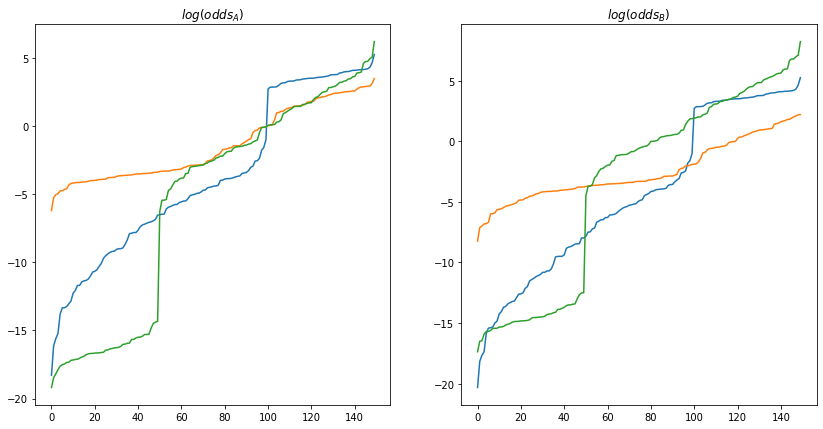

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7*2, 7))
ax1.set_title('$log(odds_A)$')
ax1.plot(np.sort(log_odds_a, axis=0))
ax2.set_title('$log(odds_B)$')
ax2.plot(np.sort(log_odds_b, axis=0));

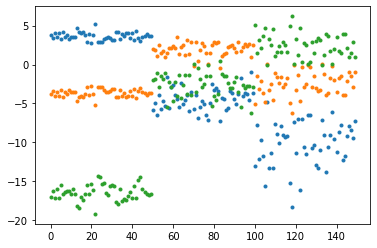

In [60]:
for log_odds in log_odds_a.T:
    plt.scatter(indices, log_odds, marker='.');

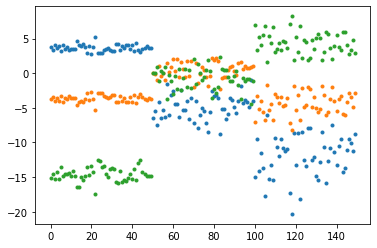

In [61]:
for log_odds in log_odds_b.T:
    plt.scatter(indices, log_odds, marker='.');